In [6]:
import copy
import pickle
import time
import numpy as np
import seaborn as sns

from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Input, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
def data_reshape(x):
    x = (x.reshape(len(x), 28 * 28)).astype(np.float64)
    x /= x.max()
    return x

def model_save(model, filename):
    pickle.dump(model, open(filename, 'wb'))

def model_load(filename):
    return pickle.load(open(filename, 'rb'))

def save_accuracy(accuracy, filename):
    with open(filename, mode='w') as f:
        for d in accuracy:
            f.write("%s\n" % d)
    
def save_times(times, filename):
    with open(filename, mode='w') as f:
        for d in times:
            f.write("%s\n" % d)

In [3]:
# 何%を検証用にするか
nVals = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# train_test_split関数に与える乱数の種値
random_state = 60

class_num = len([x for x in range(10)])

(x_train, y_train), (x_test, y_test) = load_data()
x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.9, random_state=random_state)
_, x_test, _, y_test = train_test_split(x_test, y_test, test_size=0.1, random_state=random_state)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# x_train = x_train.astype('float32')
# x_train = x_train / 255.0
# x_test = x_test.astype('float32')
# x_test = x_test / 255.0

x_train = data_reshape(x_train)
x_test = data_reshape(x_test)

# one-hot表現に変換
# y_train = to_categorical( y_train, class_num )
# y_test = to_categorical( y_test, class_num )

In [4]:
accuracies = []  # 正確度保存用
proc_time = []   # 実行時間保存用

tree_numbers = [x for x in range(1, 11)]

for tree_number in tree_numbers:
    start = time.time()
    model = RandomForestClassifier(n_estimators=tree_number, random_state=random_state)
    model.fit(x_train, y_train)
    duration = time.time() - start
    score = model.score(x_test, y_test)
    
    accuracies.append(score)
    proc_time.append(duration)
    
    filename = './Results/RandomForest/Models/randomforest-datalength=' + str(len(x_train)) + '-tree_number=' + str(tree_number) +'.pkl'
    model_save(model, filename)
    
filename = './Results/RandomForest/accuracy/randomforest-datalength=' + str(len(x_train)) + '-accuracy.txt'
save_accuracy(accuracies, filename)

filename = './Results/RandomForest/time/randomforest-datalength=' + str(len(x_train)) + '-time.txt'
save_times(proc_time, filename)

In [5]:
# earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1)
# model = use_vgg16( class_num )
# print("コンパイルします")
# model.compile(optimizer=Adam( learning_rate=1e-4 ), loss='categorical_crossentropy', metrics=['accuracy'])
# print("学習を開始します")
# history = model.fit( x=x_train, y=y_train, batch_size=4, epochs=30, verbose=1, validation_data=(x_test, y_test), callbacks=[earlystopping])
# print("モデルを保存します")
# model_save(history, './Results/vgg16-{}'.format(len(x_train)))

In [6]:
x_train.shape[1]

784

In [7]:
min(y_test)

0

In [8]:
max(y_test)

9

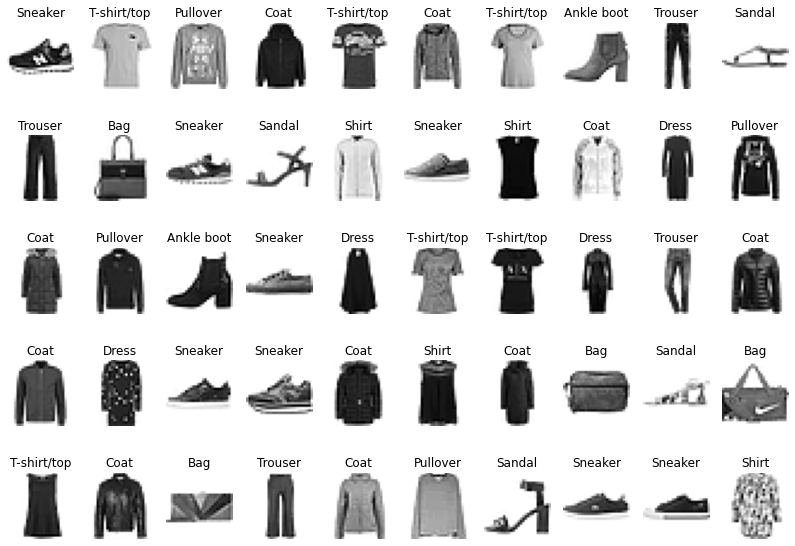

In [9]:
plt.figure(figsize=(14,10))

# 学習用データの中から乱数で適当に．．．
for i in range(5):
    for j in range(10):
        num = np.random.randint(0, high=len(y_train) )
        image = x_train[num]
        ax = plt.subplot(5, 10, 1 + 10 * i + j)
        ax.set_axis_off()
        ax.set_title( "{}".format(class_names[y_train[num]]))
        plt.imshow(image.reshape(28, 28), cmap=plt.cm.binary)
plt.show()

In [18]:
def create_model( WIDTH, HEIGHT, class_num ):
    # モデルを定義
    input_tensor = Input( shape=(HEIGHT, WIDTH, 3) )
    vgg = VGG16( include_top=False, input_tensor=input_tensor, weights=None )
    x = vgg.output
    x = Flatten()(x)
    x = Dense( 2048, activation="relu" )(x)
    x = Dropout(0.5)(x)
    x = Dense( 2048, activation="relu" )(x)
    x = Dropout(0.5)(x)
    x = Dense( class_num )(x)
    x = Activation( "softmax" )(x)
    return Model( inputs=vgg.inputs, outputs=x )

model = create_model( 400, 600, 7 )
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 600, 400, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 600, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 600, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 300, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 300, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 300, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 150, 100, 128)    

In [42]:
def use_vgg16(class_num):
    input_tensor = Input( shape=(32, 32, 1) )
    vgg = VGG16( include_top=False, input_tensor=input_tensor, weights=None, classes=class_num )
    x = vgg.output
    x = Flatten()(x)
    x = Dense( class_num, activation="relu" )(x)
    x = Dropout(0.5)(x)
    x = Activation( "softmax" )(x)
    return Model( inputs=vgg.inputs, outputs=x )

model = use_vgg16(10)
model.summary()

Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)       

In [39]:
from tensorflow.keras.applications.resnet50 import ResNet50
def create_model( WIDTH, HEIGHT, class_num ):
    # モデルを定義
    input_tensor = Input( shape=(HEIGHT, WIDTH, 3) )
    res = ResNet50( include_top=True, input_tensor=input_tensor, weights=None, classes=7 )
    return Model( inputs=res.inputs, outputs=res.output )
model = create_model( 400, 600, 7 )
model.summary()

Model: "functional_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 600, 400, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 606, 406, 3)  0           input_30[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 300, 200, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 300, 200, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [8]:
# train_test_split関数に与える乱数の種値
random_state = 60

class_num = len([x for x in range(10)])

(x_train, y_train), (x_test, y_test) = load_data()
x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.9, random_state=random_state)
_, x_test, _, y_test = train_test_split(x_test, y_test, test_size=0.1, random_state=random_state)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

x_train = x_train.astype('float32')
x_train = x_train / 255.0
x_test = x_test.astype('float32')
x_test = x_test / 255.0

# one-hot表現に変換
y_train = to_categorical( y_train, class_num )
y_test = to_categorical( y_test, class_num )

In [46]:
len(x_train)

6000

In [62]:
def model_save( model, history, filename ):
    base_path = './Results/NN/'
    h5 = base_path + 'Models/' + filename + '.h5'
    weights = base_path + 'weights/' + filename + '-weights.h5'
    pkl = base_path + 'history/'+ filename +'.pkl'
    try:
        # 保存
        model.save( h5 )
        model.save_weights( weights )

        with open( pkl, 'wb' ) as h_file:
            pickle.dump(history.history, h_file)
        print("学習結果の保存が完了しました。")
    except:
        print("保存に失敗しました。")

def create_model(class_num):
    model = Input( shape=(28, 28, 1) )
    x = Dense(100, activation="relu")(model)
    x = Dense(100, activation="relu")(x)
    x = Dense(100, activation="relu")(x)
    x = Dense(100, activation="relu")(x)
    x = Dense(100, activation="relu")(x)
    x = Flatten()(x)
    output = Dense(class_num, activation="softmax")(x)
    return Model( inputs=model, outputs=output )

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1)
model = create_model( class_num )
print("コンパイルします")
model.compile(optimizer=Adam( learning_rate=1e-4 ), loss='categorical_crossentropy', metrics=['accuracy'])
print("学習を開始します")
history = model.fit( x=x_train, y=y_train, batch_size=4,
                     epochs=50, verbose=1, validation_data=(x_test, y_test),
                   )
print("モデルを保存します")
model_save(model, history, 'NN=100×5-data={}-epochs=50'.format(len(x_train)))

コンパイルします
学習を開始します
Epoch 1/50
1500/1500 [==============================] - 18s 12ms/step - loss: 0.6834 - accuracy: 0.7597 - val_loss: 0.6636 - val_accuracy: 0.7640
Epoch 2/50
1500/1500 [==============================] - 21s 14ms/step - loss: 0.4686 - accuracy: 0.8322 - val_loss: 0.4923 - val_accuracy: 0.8100
Epoch 3/50
1500/1500 [==============================] - 22s 14ms/step - loss: 0.4249 - accuracy: 0.8463 - val_loss: 0.5245 - val_accuracy: 0.8050
Epoch 4/50
1500/1500 [==============================] - 22s 15ms/step - loss: 0.3940 - accuracy: 0.8580 - val_loss: 0.4450 - val_accuracy: 0.8450
Epoch 5/50
1500/1500 [==============================] - 22s 15ms/step - loss: 0.3684 - accuracy: 0.8670 - val_loss: 0.4506 - val_accuracy: 0.8310
Epoch 6/50
1500/1500 [==============================] - 22s 14ms/step - loss: 0.3421 - accuracy: 0.8737 - val_loss: 0.4232 - val_accuracy: 0.8490
Epoch 7/50
1500/1500 [==============================] - 21s 14ms/step - loss: 0.3251 - accuracy: 0.8810 - 

In [71]:
def create_model(class_num):
    model = Input( shape=(28, 28, 1) )
    x = Conv2D(1, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1))(model)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Flatten()(x)
    output = Dense(class_num, activation="softmax")(x)
    return Model( inputs=model, outputs=output )

model = create_model(10)
model.summary()

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1)
model = create_model( class_num )
print("コンパイルします")
model.compile(optimizer=Adam( learning_rate=1e-4 ), loss='categorical_crossentropy', metrics=['accuracy'])
print("学習を開始します")
history = model.fit( x=x_train, y=y_train, batch_size=4,
                     epochs=50, verbose=1, validation_data=(x_test, y_test),
                   )
print("モデルを保存します")
model_save(model, history, 'NN=100×5-data={}-epochs=50-conv×1'.format(len(x_train)))

Model: "functional_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 1)         10        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 1)           0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_136 (Dense)            (None, 10)                650       
Total params: 660
Trainable params: 660
Non-trainable params: 0
_________________________________________________________________
コンパイルします
学習を開始します
Epoch 1/50
1500/1500 [==============================] - 2s 1ms/step - loss: 2.1641 - accuracy: 0.2425 -

In [72]:
def create_model(class_num):
    model = Input( shape=(28, 28, 1) )
    x = Conv2D(14, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1))(model)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Conv2D(1, kernel_size=(3, 3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Flatten()(x)
    output = Dense(class_num, activation="softmax")(x)
    return Model( inputs=model, outputs=output )

model = create_model(10)
model.summary()

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1)
model = create_model( class_num )
print("コンパイルします")
model.compile(optimizer=Adam( learning_rate=1e-4 ), loss='categorical_crossentropy', metrics=['accuracy'])
print("学習を開始します")
history = model.fit( x=x_train, y=y_train, batch_size=4,
                     epochs=50, verbose=1, validation_data=(x_test, y_test),
                   )
print("モデルを保存します")
model_save(model, history, 'NN=100×5-data={}-epochs=50-conv×2'.format(len(x_train)))

Model: "functional_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 26, 26, 14)        140       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 14)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 6, 1)           127       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 2, 2, 1)           0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 4)                 0         
_________________________________________________________________
dense_138 (Dense)            (None, 10)              

In [77]:
def model_save( model, history, filename ):
    base_path = './Results/NN/'
    h5 = base_path + 'Models/' + filename + '.h5'
    weights = base_path + 'weights/' + filename + '-weights.h5'
    pkl = base_path + 'history/'+ filename +'.pkl'
    try:
        # 保存
        model.save( h5 )
        model.save_weights( weights )

        with open( pkl, 'wb' ) as h_file:
            pickle.dump(history.history, h_file)
        print("学習結果の保存が完了しました。")
    except:
        print("保存に失敗しました。")

def create_model(class_num):
    model = Input( shape=(28, 28, 1) )
    x = Dense(100, activation="relu")(model)
    x = Dense(100, activation="relu")(x)
    x = Dense(100, activation="relu")(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation="relu")(x)
    x = Flatten()(x)
    output = Dense(class_num, activation="softmax")(x)
    return Model( inputs=model, outputs=output )

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1)
model = create_model( class_num )
print("コンパイルします")
model.compile(optimizer=Adam( learning_rate=1e-4 ), loss='categorical_crossentropy', metrics=['accuracy'])
print("学習を開始します")
history = model.fit( x=x_train, y=y_train, batch_size=4,
                     epochs=50, verbose=1, validation_data=(x_test, y_test),
                   )
print("モデルを保存します")
model_save(model, history, 'NN=100×5-dropout×1-data={}-epochs=50'.format(len(x_train)))

コンパイルします
学習を開始します
Epoch 1/50
1500/1500 [==============================] - 22s 14ms/step - loss: 0.7368 - accuracy: 0.7428 - val_loss: 0.5994 - val_accuracy: 0.7650
Epoch 2/50
1500/1500 [==============================] - 24s 16ms/step - loss: 0.5089 - accuracy: 0.8188 - val_loss: 0.5323 - val_accuracy: 0.8170
Epoch 3/50
1500/1500 [==============================] - 25s 17ms/step - loss: 0.4582 - accuracy: 0.8355 - val_loss: 0.4848 - val_accuracy: 0.8340
Epoch 4/50
1500/1500 [==============================] - 27s 18ms/step - loss: 0.4370 - accuracy: 0.8433 - val_loss: 0.4699 - val_accuracy: 0.8280
Epoch 5/50
1500/1500 [==============================] - 27s 18ms/step - loss: 0.4119 - accuracy: 0.8505 - val_loss: 0.4859 - val_accuracy: 0.8300
Epoch 6/50
1500/1500 [==============================] - 25s 17ms/step - loss: 0.3955 - accuracy: 0.8598 - val_loss: 0.4781 - val_accuracy: 0.8230
Epoch 7/50
1500/1500 [==============================] - 26s 17ms/step - loss: 0.3731 - accuracy: 0.8698 - 

In [78]:
def create_model(class_num):
    model = Input( shape=(28, 28, 1) )
    x = Dense(100, activation="relu")(model)
    x = Dense(100, activation="relu")(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation="relu")(x)
    x = Flatten()(x)
    output = Dense(class_num, activation="softmax")(x)
    return Model( inputs=model, outputs=output )

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1)
model = create_model( class_num )
print("コンパイルします")
model.compile(optimizer=Adam( learning_rate=1e-4 ), loss='categorical_crossentropy', metrics=['accuracy'])
print("学習を開始します")
history = model.fit( x=x_train, y=y_train, batch_size=4,
                     epochs=50, verbose=1, validation_data=(x_test, y_test),
                   )
print("モデルを保存します")
model_save(model, history, 'NN=100×5-dropout×2-data={}-epochs=50'.format(len(x_train)))

コンパイルします
学習を開始します
Epoch 1/50
1500/1500 [==============================] - 27s 18ms/step - loss: 0.7548 - accuracy: 0.7360 - val_loss: 0.6359 - val_accuracy: 0.7420
Epoch 2/50
1500/1500 [==============================] - 29s 20ms/step - loss: 0.5337 - accuracy: 0.8130 - val_loss: 0.5288 - val_accuracy: 0.8070
Epoch 3/50
1500/1500 [==============================] - 31s 21ms/step - loss: 0.4875 - accuracy: 0.8305 - val_loss: 0.5611 - val_accuracy: 0.8120
Epoch 4/50
1500/1500 [==============================] - 32s 22ms/step - loss: 0.4541 - accuracy: 0.8388 - val_loss: 0.4997 - val_accuracy: 0.8260
Epoch 5/50
1500/1500 [==============================] - 31s 21ms/step - loss: 0.4257 - accuracy: 0.8485 - val_loss: 0.4854 - val_accuracy: 0.8160
Epoch 6/50
1500/1500 [==============================] - 28s 19ms/step - loss: 0.4160 - accuracy: 0.8497 - val_loss: 0.4737 - val_accuracy: 0.8440
Epoch 7/50
1500/1500 [==============================] - 31s 21ms/step - loss: 0.4001 - accuracy: 0.8567 - 

In [79]:
def create_model(class_num):
    model = Input( shape=(28, 28, 1) )
    x = Conv2D(16, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1))(model)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Conv2D(8, kernel_size=(3, 3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Flatten()(x)
    output = Dense(class_num, activation="softmax")(x)
    return Model( inputs=model, outputs=output )

model = create_model(10)
model.summary()

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1)
model = create_model( class_num )
print("コンパイルします")
model.compile(optimizer=Adam( learning_rate=1e-4 ), loss='categorical_crossentropy', metrics=['accuracy'])
print("学習を開始します")
history = model.fit( x=x_train, y=y_train, batch_size=4,
                     epochs=50, verbose=1, validation_data=(x_test, y_test),
                   )
print("モデルを保存します")
model_save(model, history, 'NN=100×5-data={}-epochs=50-conv×2_model=2'.format(len(x_train)))

Model: "functional_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 6, 6, 8)           1160      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 2, 2, 8)           0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_159 (Dense)            (None, 10)              

In [4]:
def model_save( model, history, filename ):
    base_path = './Results/NN/'
    h5 = base_path + 'Models/' + filename + '.h5'
    weights = base_path + 'weights/' + filename + '-weights.h5'
    pkl = base_path + 'history/'+ filename +'.pkl'
    try:
        # 保存
        model.save( h5 )
        model.save_weights( weights )

        with open( pkl, 'wb' ) as h_file:
            pickle.dump(history.history, h_file)
        print("学習結果の保存が完了しました。")
    except:
        print("保存に失敗しました。")

def create_model(class_num):
    model = Input( shape=(28, 28, 1) )
    x = Conv2D(1, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1))(model)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Flatten()(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(class_num, activation="softmax")(x)
    return Model( inputs=model, outputs=output )

model = create_model(10)
model.summary()

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1)
model = create_model( class_num )
print("コンパイルします")
model.compile(optimizer=Adam( learning_rate=1e-4 ), loss='categorical_crossentropy', metrics=['accuracy'])
print("学習を開始します")
history = model.fit( x=x_train, y=y_train, batch_size=4,
                     epochs=200, verbose=1, validation_data=(x_test, y_test),
                     callbacks=[earlystopping]
                   )
print("モデルを保存します")
model_save(model, history, 'NN=100×5-dropout×5-data={}-epochs=200-conv×1'.format(len(x_train)))

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 1)         10        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 1)           0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)              

In [5]:
def model_save( model, history, filename ):
    base_path = './Results/NN/'
    h5 = base_path + 'Models/' + filename + '.h5'
    weights = base_path + 'weights/' + filename + '-weights.h5'
    pkl = base_path + 'history/'+ filename +'.pkl'
    try:
        # 保存
        model.save( h5 )
        model.save_weights( weights )

        with open( pkl, 'wb' ) as h_file:
            pickle.dump(history.history, h_file)
        print("学習結果の保存が完了しました。")
    except:
        print("保存に失敗しました。")

def create_model(class_num):
    model = Input( shape=(28, 28, 1) )
    x = Conv2D(1, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1))(model)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Flatten()(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(class_num, activation="softmax")(x)
    return Model( inputs=model, outputs=output )

model = create_model(10)
model.summary()

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1)
model = create_model( class_num )
print("コンパイルします")
model.compile(optimizer=Adam( learning_rate=1e-4 ), loss='categorical_crossentropy', metrics=['accuracy'])
print("学習を開始します")
history = model.fit( x=x_train, y=y_train, batch_size=4,
                     epochs=200, verbose=1, validation_data=(x_test, y_test),
                     callbacks=[earlystopping]
                   )
print("モデルを保存します")
model_save(model, history, 'NN=100×5-dropout×5-data={}-epochs=200-conv×1'.format(len(x_train)))

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 1)         10        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 1)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               6500      
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)              

In [10]:
def model_save( model, history, filename ):
    base_path = './Results/NN/'
    h5 = base_path + 'Models/' + filename + '.h5'
    weights = base_path + 'weights/' + filename + '-weights.h5'
    pkl = base_path + 'history/'+ filename +'.pkl'
    try:
        # 保存
        model.save( h5 )
        model.save_weights( weights )

        with open( pkl, 'wb' ) as h_file:
            pickle.dump(history.history, h_file)
        print("学習結果の保存が完了しました。")
    except:
        print("保存に失敗しました。")

def create_model(class_num):
    model = Input( shape=(28, 28, 1) )
    x = Conv2D(16, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1))(model)
    x = Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
    x = Conv2D(1, kernel_size=(3, 3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Flatten()(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(class_num, activation="softmax")(x)
    return Model( inputs=model, outputs=output )

model = create_model(10)
model.summary()

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1)
model = create_model( class_num )
print("コンパイルします")
model.compile(optimizer=Adam( learning_rate=1e-4 ), loss='categorical_crossentropy', metrics=['accuracy'])
print("学習を開始します")
history = model.fit( x=x_train, y=y_train, batch_size=4,
                     epochs=200, verbose=1, validation_data=(x_test, y_test),
                     callbacks=[earlystopping]
                   )
print("モデルを保存します")
model_save(model, history, 'NN=100×5-dropout×5-data={}-epochs=200-conv×3'.format(len(x_train)))

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 22, 22, 1)         289       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 1)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 49)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 100)              